# Mean Shift for 2D points
- https://en.wikipedia.org/wiki/Mean_shift
- https://spin.atomicobject.com/2015/05/26/mean-shift-clustering/

Import libraires

In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from sklearn.datasets import *
%matplotlib inline
pylab.rcParams['figure.figsize'] = 16, 12

Generate a set of 100 datapoints from 4 clusters. We will also ploit it out to see what it looks like.
(used Scikit-Learn’s datasets make_blobs)


(100, 2)


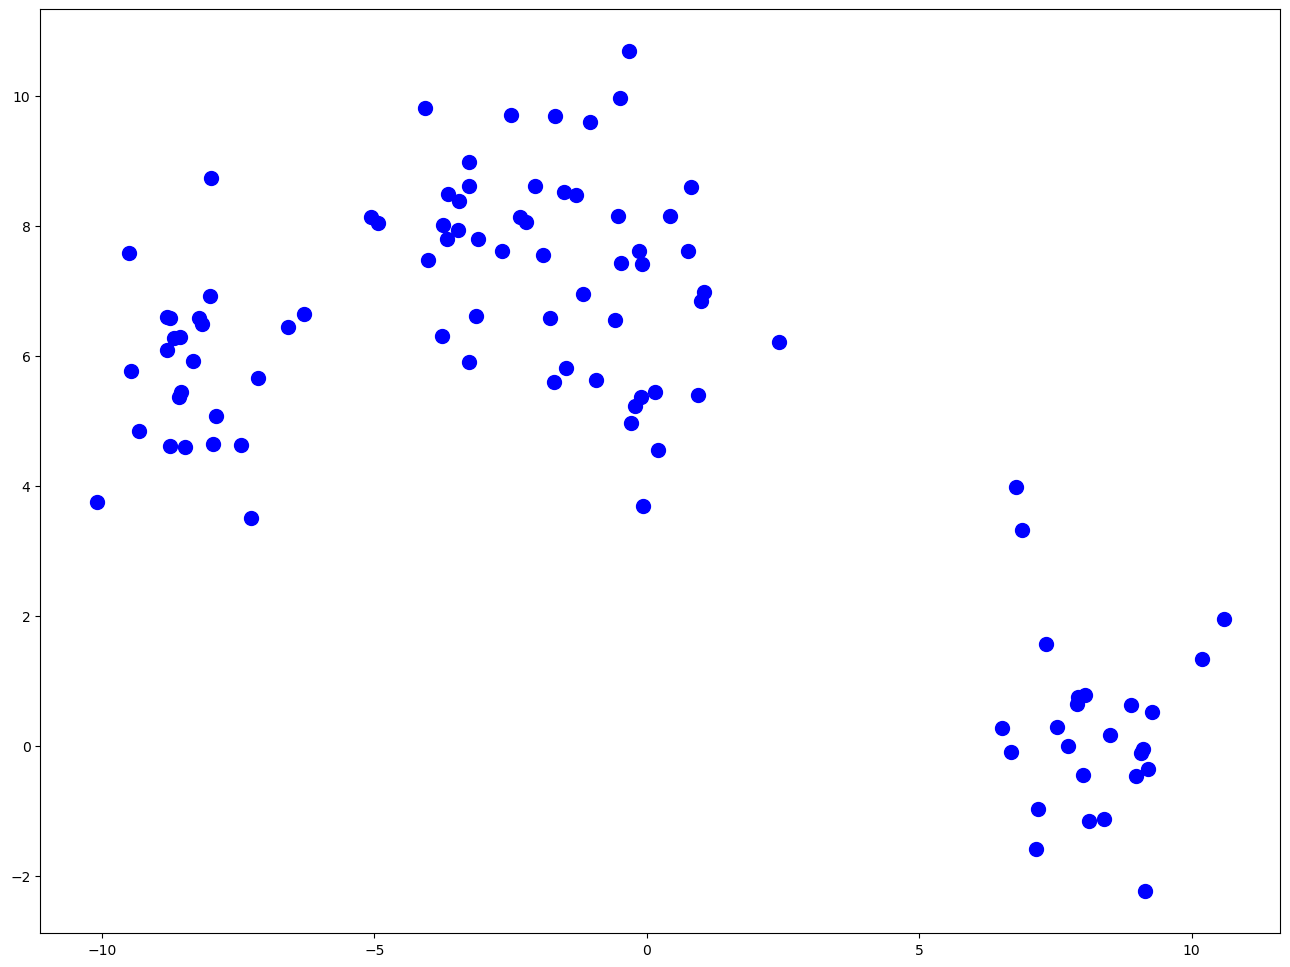

In [2]:
original_X, X_shapes = make_blobs(100, 2, centers=4, cluster_std=1.3)
print(original_X.shape)
plt.plot(original_X[:,0], original_X[:,1], 'bo', markersize = 10)

Defining the Euclidean Distance function used for evaluating the neighbour of points. Define the Gaussian Kernel used for calculating the Meanshift Vector.



In [3]:
# Defining the kernel, euclidean distance, neighbourhood functions we need 
def euclid_distance(x, xi):
    return np.sqrt(np.sum((x - xi)**2))

def neighbourhood_points(X, x_centroid, distance = 5):
    eligible_X = []
    for x in X:
        distance_between = euclid_distance(x, x_centroid)
        # print('Evaluating: [%s vs %s] yield dist=%.2f' % (x, x_centroid, distance_between))
        if distance_between <= distance:
            eligible_X.append(x)
    return eligible_X

def gaussian_kernel(distance, bandwidth):
    val = (1/(bandwidth*math.sqrt(2*math.pi))) * np.exp(-0.5*((distance / bandwidth))**2)
    return val

We pick the parameters on how to select neighbouring points and the parameters of the kernel. This will need to be tuned for different datasets. For example, the kernel bandwidith can be estimated using the sklearn.cluster.estimate_bandwidth. In our case, we will keep things simple and pick a reasonable number.



In [4]:
look_distance = 6  # How far to look for neighbours.
kernel_bandwidth = 4  # Kernel parameter.

The Meanshift Algorithm in action.

- For each datapoint x in X, find the neighbouring points N(x) of x.
- For each datapoint x in X, calculate the mean shift m(x).
- For each datapoint x in X, update x from m(x).
- Repeat 1. for n_iterations or until the points are almost not moving or not moving.

We can change the n_iterations below to run more iterations of Meanshift.

In [5]:
# Naive Implementing Meanshift
"""
There are a lot of optimizations that can be done to improve this code’s speed. 
For instance, 
1) Vectorize the implementation above, 
2) Use a Ball Tree to calculate the neighbourhood points much more efficiently, etc.
"""

X = np.copy(original_X)
# print('Initial X: ', X)

past_X = []
n_iterations = 5
for it in range(n_iterations):
    # print('Iteration [%d]' % (it))

    for i, x in enumerate(X):
        ### Step 1. For each datapoint x in X, find the neighbouring points N(x) of x.
        neighbours = neighbourhood_points(X, x, look_distance)
        # print('[%s] has neighbours [%d]' % (x, len(neighbours)))

        ### Step 2. For each datapoint x in X, calculate the mean shift m(x).
        numerator = 0
        denominator = 0
        for neighbour in neighbours:
            distance = euclid_distance(neighbour, x)
            weight = gaussian_kernel(distance, kernel_bandwidth)
            numerator += (weight * neighbour)
            denominator += weight

        new_x = numerator / denominator

        ### Step 3. For each datapoint x in X, update x from m(x).
        X[i] = new_x

    # print('New X: ', X)
    past_X.append(np.copy(X))

Now let us visualize what happens with the datapoints.



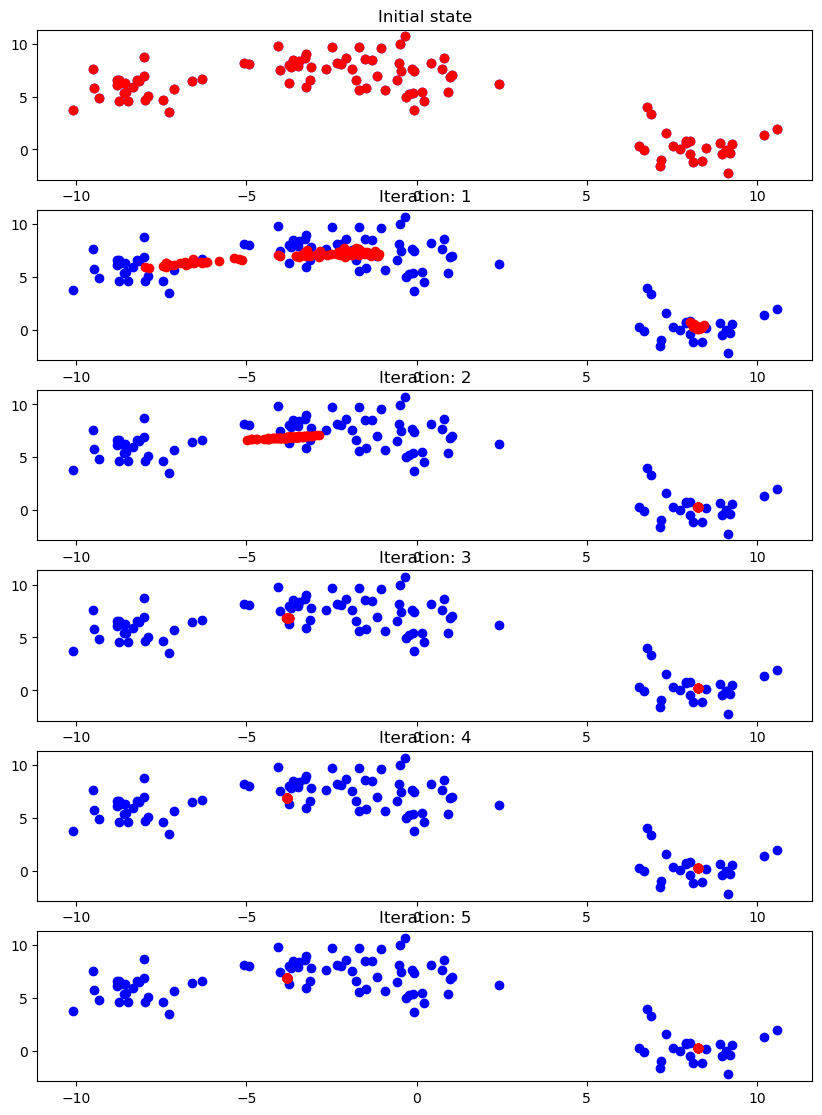

In [6]:
figure = plt.figure(1)
figure.set_size_inches((10, 16))
plt.subplot(n_iterations + 2, 1, 1)
plt.title('Initial state')
plt.plot(original_X[:,0], original_X[:,1], 'bo')
plt.plot(original_X[:,0], original_X[:,1], 'ro')

for i in range(n_iterations):
    figure_index = i + 2
    plt.subplot(n_iterations + 2, 1, figure_index)
    plt.title('Iteration: %d' % (figure_index - 1))
    plt.plot(original_X[:,0], original_X[:,1], 'bo')
    plt.plot(past_X[i][:,0], past_X[i][:,1], 'ro')

The blue datapoints are the initial datapoints and red are the positions of those datapoints at each iteration. Description for each step:

Iteration:

1. Initial state. The red and blue datapoints overlap completely in the first iteration before the Meanshift algorithm starts.
2. End of iteration 1. All the red datapoints move closer to clusters. Looks like there will be 4 clusters.
3. End of iteration 2. The clusters of upper right and lower left seems to have reached convergence just using two iterations. The center and lower right clusters looks like they are merging, since the two centroids are very close.
4. End of iteration 3. No change in the upper right and lower left centroids. The other two centroids’ have pulled each other together as the datapoints affect each clusters. This is a signature of Meanshift, the number of clusters are not pre-determined.
5. End of iteration 4. All the clusters should have converged.
6. End of iteration 5. All the clusters indeed have no movement. The algorithm stops here since no change is detected for all red datapoints.